# Modelling version-3:

In the first version, we tried creating a baseline model using a subset of pages. We developed a single model that captures the temporal relationships for each of the pages and is able to predict the number of visits. 

In this notebook, we will use LSTM to create a model that is able to perform more accurately while handling a larger subset of pages. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.metrics import mean_absolute_error
import optuna

/Users/mehuljain/miniconda3/envs/capstone_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import pytorch 

In [2]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


Import neural forecast

In [3]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import DistributionLoss

## Load the data:

In [4]:
PATH= "../data/train_1.csv"

In [5]:
df= pd.read_csv(PATH)

In [6]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


What are the columns in the dataset?

In [8]:
df.columns

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=551)

Other dataframes

In [9]:
# PATH_2= "../data/key_1.csv"

In [10]:
# key_df= pd.read_csv(PATH_2)

In [11]:
# key_df.head()

In [12]:
# key_df.shape

`key_df` contains the alpha-numeric ID for each Page and Date combination

In [13]:
# for example
# key_df.iloc[1].Page

## Melt the dataframe:

First, drop rows with null values

In [14]:
df=df.dropna()

In [15]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


Take a sample from the dataframe

In [16]:
df_sample=df.sample(n=5, random_state=42)

In [17]:
df_sample.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
42042,Luis_Suárez_en.wikipedia.org_all-access_all-ag...,4261.0,3872.0,3896.0,4270.0,3973.0,4300.0,4115.0,4028.0,3846.0,...,4437.0,3676.0,3226.0,3291.0,3836.0,4008.0,4092.0,3764.0,3719.0,3477.0
99800,"Фрейзер,_Джо_ru.wikipedia.org_all-access_all-a...",291.0,347.0,335.0,305.0,283.0,270.0,302.0,327.0,303.0,...,421.0,391.0,528.0,418.0,403.0,356.0,379.0,388.0,365.0,243.0
53520,Dr_House_fr.wikipedia.org_mobile-web_all-agents,304.0,264.0,417.0,230.0,1002.0,406.0,318.0,321.0,345.0,...,450.0,442.0,335.0,373.0,914.0,728.0,961.0,1648.0,501.0,500.0
80024,File:Penny_black.jpg_commons.wikimedia.org_mob...,0.0,1.0,5.0,0.0,0.0,1.0,0.0,2.0,0.0,...,1.0,0.0,2.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0
106799,射鵰英雄傳_(2008年電視劇)_zh.wikipedia.org_mobile-web_a...,121.0,107.0,107.0,117.0,107.0,111.0,114.0,105.0,105.0,...,339.0,387.0,178.0,179.0,339.0,330.0,387.0,342.0,524.0,218.0


Now melt the dataframe

In [18]:
melted= df_sample.melt(id_vars='Page',var_name='Date' , value_name= 'Visits')

Let's check out the melted dataframe

In [19]:
melted.head(10)

,Page,Date,Visits
0,Luis_Suárez_en.wikipedia.org_all-access_all-ag...,2015-07-01,4261.0
1,"Фрейзер,_Джо_ru.wikipedia.org_all-access_all-a...",2015-07-01,291.0
2,Dr_House_fr.wikipedia.org_mobile-web_all-agents,2015-07-01,304.0
3,File:Penny_black.jpg_commons.wikimedia.org_mob...,2015-07-01,0.0
4,射鵰英雄傳_(2008年電視劇)_zh.wikipedia.org_mobile-web_a...,2015-07-01,121.0
5,Steyr_(Traktorenhersteller)_de.wikipedia.org_d...,2015-07-01,58.0
6,Category:Nude_in_photography_commons.wikimedia...,2015-07-01,98.0
7,張善為_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
8,Bahlika_en.wikipedia.org_all-access_all-agents,2015-07-01,11.0
9,Ronaldinho_es.wikipedia.org_desktop_all-agents,2015-07-01,2804.0


## Splitting the data:

Split the data into training and validation set

In [20]:
melted['DateTime'] = pd.to_datetime(melted['Date'])

In [21]:
melted.Date.min(), melted.Date.max()

('2015-07-01', '2016-12-31')

Add a time step column

In [22]:
earliest_date=melted.DateTime.min()
melted['time_step'] = (melted['DateTime'] - earliest_date).dt.days

Get days of the week

In [23]:
weekday= pd.get_dummies(melted['DateTime'].dt.weekday)
weekday.columns=['weekday_'+str(i) for i in range(weekday.shape[1])]
melted= pd.concat([melted, weekday], axis=1)

In [24]:
melted.tail()

,Page,Date,Visits,DateTime,time_step,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
27495,觀世音菩薩_zh.wikipedia.org_all-access_all-agents,2016-12-31,515.0,2016-12-31,549,False,False,False,False,False,True,False
27496,Urraca_I_de_León_es.wikipedia.org_all-access_a...,2016-12-31,144.0,2016-12-31,549,False,False,False,False,False,True,False
27497,День_сурка_ru.wikipedia.org_mobile-web_all-agents,2016-12-31,67.0,2016-12-31,549,False,False,False,False,False,True,False
27498,Gisele_Bündchen_fr.wikipedia.org_all-access_sp...,2016-12-31,8.0,2016-12-31,549,False,False,False,False,False,True,False
27499,ワンパンマン_ja.wikipedia.org_mobile-web_all-agents,2016-12-31,1496.0,2016-12-31,549,False,False,False,False,False,True,False


Rename some columns before splitting

In [25]:
# Renaming columns inplace
melted.rename(columns={'DateTime': 'ds', 'Visits': 'y','Page':'unique_id'}, inplace=True)

Use the last month data as validation data

In [26]:
train=melted[melted['time_step']<520].copy()
valid=melted[melted['time_step']>=520].copy()

In [27]:
train=train[['ds','y','unique_id']+ list(weekday.columns)]
valid=valid[['ds','y','unique_id']+ list(weekday.columns)]

In [28]:
h = valid['ds'].nunique()

## Training LSTM model:

In [29]:
models = [LSTM(h=h,
               loss=DistributionLoss(distribution='Normal', level=[90]),
               max_steps=100,
               encoder_n_layers=2,
               encoder_hidden_size=200,
               context_size=10,
               decoder_hidden_size=200,
               decoder_layers=2,
               learning_rate=1e-3,
               scaler_type='standard',
               )]

model = NeuralForecast(models=models, freq='D')

Seed set to 1


Train the model

In [30]:
# model.fit(train)

In [32]:
# p =  model.predict(futr_df=valid).reset_index()
# p = p.merge(valid[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='left')

In [34]:
# p

Check the performance of the model 

In [35]:
def smape(actual, forecast):
    result = 1/len(actual) * np.sum(2*np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)
    return result

In [37]:
# smape(p['y'],p['LSTM'])

Let's plot our predictions

In [39]:
# fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
# ax = ax.flatten()
# for ax_ ,family in enumerate(p['unique_id'].unique()[:6]):
#     p_ = p.loc[p['unique_id'] == family]
#     p_.plot(x='ds', y='y', ax=ax[ax_], label='Visits')
#     p_.plot(x='ds', y='LSTM', ax=ax[ax_], label='Forecast')
#     ax[ax_].set_title(family)
#     ax[ax_].legend()
#     ax[ax_].set_xlabel('Date')
#     ax[ax_].set_ylabel('Sales')
# fig.tight_layout()
# plt.show()

## Optimize Hyperparameters:

In [40]:
def objective(trial):
    encoder_n_layers = trial.suggest_int('encoder_n_layers', 1, 3)
    encoder_hidden_size = trial.suggest_categorical('encoder_hidden_size', [64, 128, 256])
    decoder_layers = trial.suggest_int('decoder_layers', 1, 3)
    decoder_hidden_size = trial.suggest_categorical('decoder_hidden_size', [64, 128, 256])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    context_size = trial.suggest_int('context_size', 1, 60)
    scaler_type = trial.suggest_categorical('scaler_type', ['standard'])

    models = [LSTM(h=h,
                   loss=DistributionLoss(distribution='Normal', level=[90]),
                   max_steps=100,
                   encoder_n_layers=encoder_n_layers,
                   encoder_hidden_size=encoder_hidden_size,
                   context_size=context_size,
                   decoder_hidden_size=decoder_hidden_size,
                   decoder_layers=decoder_layers,
                   learning_rate=learning_rate,
                   scaler_type=scaler_type,
                   )]

    model = NeuralForecast(models=models, freq='D')
    model.fit(train)

    p = model.predict(futr_df=valid).reset_index()
    p = p.merge(valid[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

    loss = mean_absolute_error(p['y'], p['LSTM']) 

    return loss

In [41]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2)

[I 2024-06-08 18:50:00,103] A new study created in memory with name: no-name-ba17bdce-26dd-4874-992a-9060a2a3fc22
/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_84371/1065816482.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss            | DistributionLoss | 3     
1 | padder          | ConstantPad1d    | 0     
2 | scaler          | TemporalNorm     | 0     
3 | hist_encoder    | LSTM             | 265 K 
4 | context_adapter | Linear           | 138 K 
5 | mlp_decoder    

Epoch 49: 100%|██████████| 2/2 [00:00<00:00,  7.15it/s, v_num=29, train_loss_step=13.40, train_loss_epoch=13.50]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 49: 100%|██████████| 2/2 [00:00<00:00,  6.97it/s, v_num=29, train_loss_step=13.40, train_loss_epoch=13.50]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

[W 2024-06-08 18:50:18,917] Trial 0 failed with parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 256, 'decoder_layers': 2, 'decoder_hidden_size': 128, 'learning_rate': 0.07943850439537331, 'context_size': 18, 'scaler_type': 'standard'} because of the following error: RuntimeError('MPS backend out of memory (MPS allocated: 11.21 GB, other allocations: 3.75 GB, max allowed: 18.13 GB). Tried to allocate 3.72 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).').
Traceback (most recent call last):
  File "/Users/mehuljain/miniconda3/envs/capstone_2/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_84371/1065816482.py", line 25, in objective
    p = model.predict(futr_df=valid).reset_index()
  File "/Users/mehuljain/miniconda3/envs/capstone_2/lib/python3.9/site-packages/

RuntimeError: MPS backend out of memory (MPS allocated: 11.21 GB, other allocations: 3.75 GB, max allowed: 18.13 GB). Tried to allocate 3.72 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
study.best_params

{'encoder_n_layers': 3,
 'encoder_hidden_size': 64,
 'decoder_layers': 3,
 'decoder_hidden_size': 128,
 'learning_rate': 0.001972452310804088,
 'context_size': 31,
 'scaler_type': 'standard'}

Plot the predictions

In [ ]:
models = [LSTM(h=h,
               loss=DistributionLoss(distribution='Normal', level=[90]),
               max_steps=100,
               encoder_n_layers=3,
               encoder_hidden_size=64,
               context_size=26,
               decoder_hidden_size=256,
               decoder_layers=3,
               learning_rate=3e-4,
               scaler_type='standard',
               )]

model = NeuralForecast(models=models, freq='D')

Seed set to 1


In [ ]:
model.fit(train)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss            | DistributionLoss | 3     
1 | padder          | ConstantPad1d    | 0     
2 | scaler          | TemporalNorm     | 0     
3 | hist_encoder    | LSTM             | 83.7 K
4 | context_adapter | Linear           | 50.7 K
5 | mlp_decoder     | MLP              | 73.2 K
-----------------------------------------------------
207 K     Trainable params
3         Non-trainable params
207 K     Total params
0.831     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, v_num=27, train_loss_step=6.050, train_loss_epoch=6.050]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, v_num=27, train_loss_step=6.050, train_loss_epoch=6.050]


In [ ]:
p =  model.predict(futr_df=valid).reset_index()
p = p.merge(valid[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='left')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.48it/s]


/Users/mehuljain/miniconda3/envs/capstone_2/lib/python3.9/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


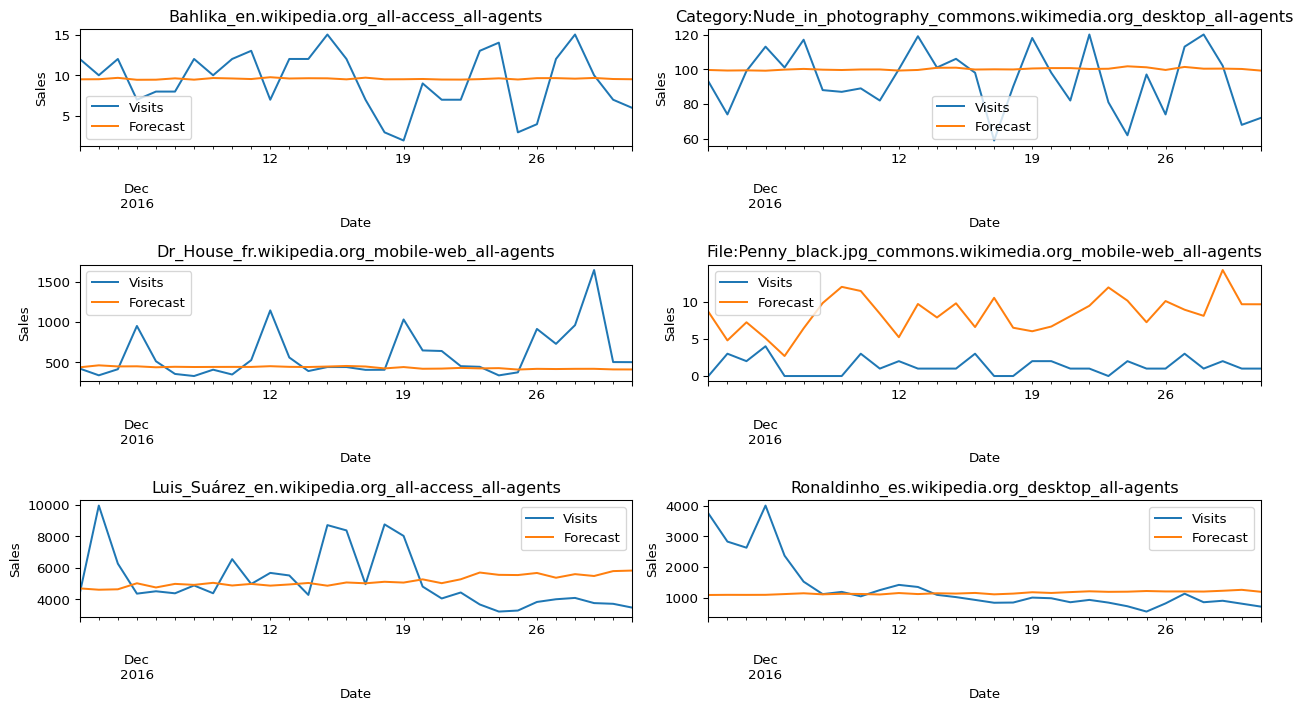

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()
for ax_ ,family in enumerate(p['unique_id'].unique()[:6]):
    p_ = p.loc[p['unique_id'] == family]
    p_.plot(x='ds', y='y', ax=ax[ax_], label='Visits')
    p_.plot(x='ds', y='LSTM', ax=ax[ax_], label='Forecast')
    ax[ax_].set_title(family)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sales')
fig.tight_layout()
plt.show()

In [ ]:
smape(p['y'],p['LSTM'])

54.317809633167826